In [1]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

In [3]:
dl = DataLib("SignalData")

## Question 1

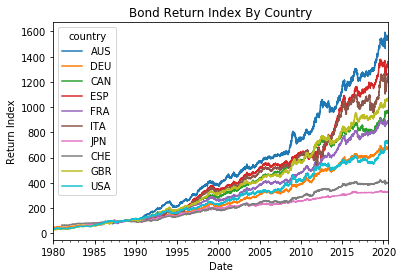

country     AUS     DEU  CAN  ESP  FRA  ITA  JPN  CHE     GBR     USA
date                                                                 
1980-01-01  NaN  49.321  NaN  NaN  NaN  NaN  NaN  NaN  26.143  37.527
1980-01-02  NaN  49.330  NaN  NaN  NaN  NaN  NaN  NaN  25.882  37.156
1980-01-03  NaN  49.163  NaN  NaN  NaN  NaN  NaN  NaN  25.911  36.941
1980-01-04  NaN  49.116  NaN  NaN  NaN  NaN  NaN  NaN  26.123  36.859
1980-01-07  NaN  49.125  NaN  NaN  NaN  NaN  NaN  NaN  26.268  36.926


In [37]:
bondReturnIndex = dl.pull('BondRetIdx/LocalFX')
bondReturnIndex.plot()
plt.xlabel('Date')
plt.ylabel('Return Index')
plt.title('Bond Return Index By Country')
plt.show()
print(bondReturnIndex.head())

## Question 2

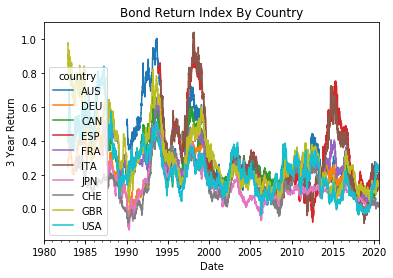

In [5]:
rolling3YearReturn = bondReturnIndex.pct_change(3*251)
rolling3YearReturn.plot()
plt.xlabel('Date')
plt.ylabel('3 Year Return')
plt.title('Bond Return Index By Country')
plt.show()

Spain and Italy had bond market rallies in 2013. At that point, they seemed to be going through a depression so when people deposited their money in domestic banks, the banks purchased long-maturing bonds to keep the money safe and since they could not invest in equities as there was a recession. Then, since demand increased, the price increased.

## Questions 3

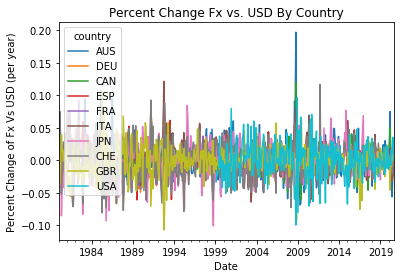

In [7]:
fxVsUSD = dl.pull('fxVsUSD')
monthlyFxVsUSD = fxVsUSD.resample('M').mean()
fxVsUSDPctChange = monthlyFxVsUSD.pct_change(periods = 1)
fxVsUSDPctChange.plot()
plt.xlabel('Date')
plt.ylabel('Percent Change of Fx Vs USD (per year)')
plt.title('Percent Change Fx vs. USD By Country')
plt.show()

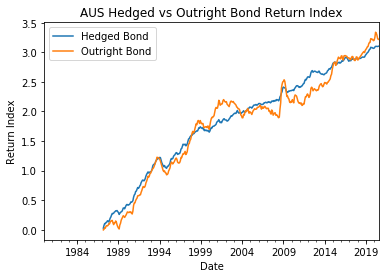

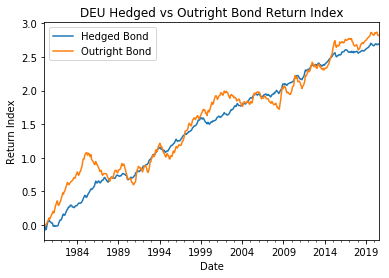

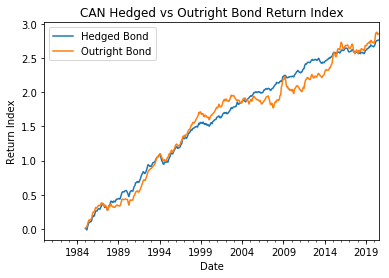

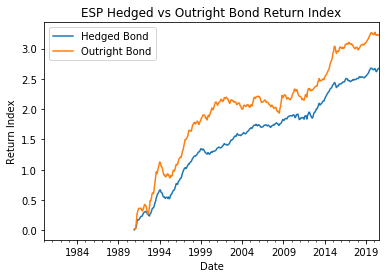

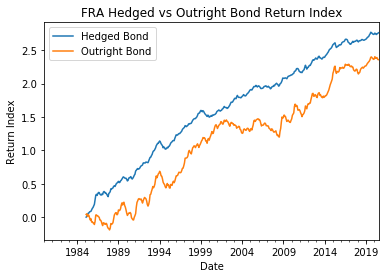

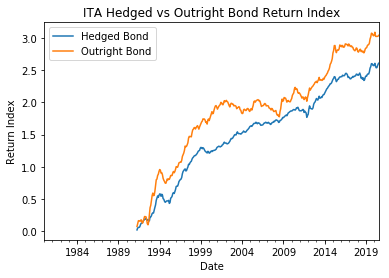

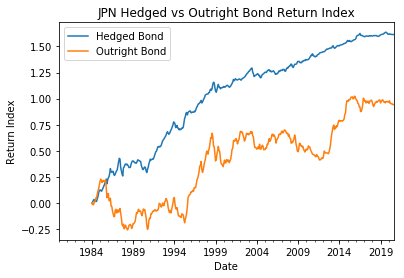

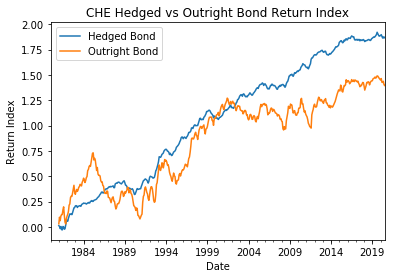

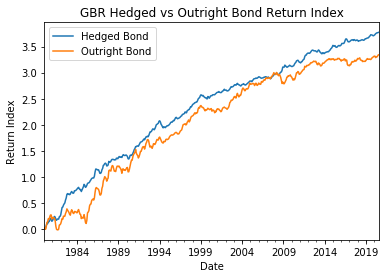

In [36]:
monthlyBondReturns = bondReturnIndex.resample('M').mean().pct_change()
hedgedBonds = monthlyBondReturns #- 0.2 / 100
outrightBonds = (monthlyBondReturns + 1) * (fxVsUSDPctChange + 1) - 1
hedgedIndex = hedgedBonds.cumsum()
outrightIndex = outrightBonds.cumsum()
# hedgedIndex = (hedgedBonds + 1).cumprod()
# outrightIndex = (outrightBonds + 1).cumprod()
# print(hedgedBonds.tail())
# print(outrightBonds.tail())
# print(hedgedIndex.tail())
# print(outrightIndex.tail())

for country in hedgedIndex.columns:
    if country != 'USA':
        hedgedIndex[country].plot()
        outrightIndex[country].plot()
        plt.legend(['Hedged Bond', 'Outright Bond'])
        plt.xlabel('Date')
        plt.ylabel('Return Index')
        plt.title(country + ' Hedged vs Outright Bond Return Index')
        plt.show()

## Question 4

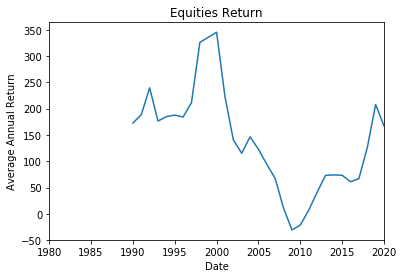

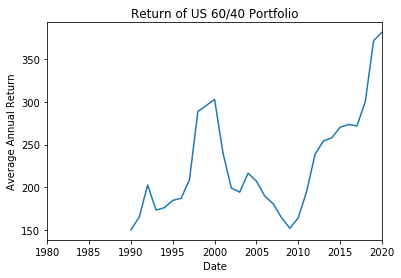

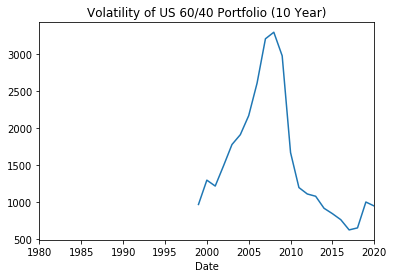

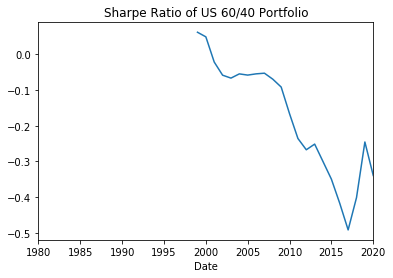

In [153]:
'''
pull equity prices (put them into yearly numbers). need returns so calculate returns by getting
percent change from ten years prior, then multiply by 100 to get value in base points. Then 
weight portfolio 60% US equities 40% US bonds 
'''
equityPrices = dl.pull('EquityPrices')
yearlyEquityPrices = equityPrices.groupby(equityPrices.index.year).mean()
yearlyEquityReturns = yearlyEquityPrices.pct_change(periods = 10) * 100

yearlyEquityReturns['USA'].plot()
plt.xlabel('Date')
plt.ylabel('Average Annual Return')
plt.title('Equities Return')
plt.show()

us6040Portfolio = yearlyEquityReturns['USA'] * 0.6 + yearlyBondReturns['USA'] * 0.4

us6040Portfolio.plot()
plt.xlabel('Date')
plt.ylabel('Average Annual Return')
plt.title('Return of US 60/40 Portfolio')
plt.show()


'''
calulate the volatility using formula (weight * std deviation)^2 + rho * std deviation * weight.
to get the standard deviation, i took a window of 10 years
'''
stdEquities = yearlyEquityReturns['USA'].rolling(10).std()
stdBonds = yearlyBondReturns['USA'].rolling(10).std()
corrCoef = yearlyEquityReturns['USA'].corr(yearlyBondReturns['USA'])
volatility6040Portfolio = (0.6 * stdEquities)**2 + (0.4 * stdBonds)**2 \
    + 2 * 0.6 * 0.4 * corrCoef * stdEquities * stdBonds
volatility6040Portfolio.plot()
plt.xlabel('Date')
plt.title('Volatility of US 60/40 Portfolio (10 Year)')
plt.show()


'''
calculate the sharpe ratio by subtracting risk free rate (used US bond rate unsure how to find rate
for only US treasury bonds) from return of 60/40 portfolion and then divided by volatility
'''
sharpeRatio = (us6040Portfolio - yearlyBondReturns['USA']) / (volatility6040Portfolio)
sharpeRatio.plot()
plt.xlabel('Date')
plt.title('Sharpe Ratio of US 60/40 Portfolio')
plt.show()

date
1980    10.151716
1981    10.371063
1982    13.933910
1983    21.863890
1984    28.082831
dtype: float64


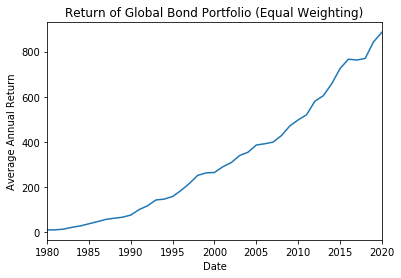

In [119]:
# useful variables: hedgedBonds, yearlyBondReturns
globalBondPortfolio = hedgedBonds
for country in globalBondPortfolio.columns:
    globalBondPortfolio[country] = globalBondPortfolio[country] * 0.1

globalBondPortfolio = globalBondPortfolio.sum(axis = 1)
globalBondPortfolio.plot()
plt.xlabel('Date')
plt.ylabel('Average Annual Return')
plt.title('Return of Global Bond Portfolio (Equal Weighting)')
plt.show()

## Question 5

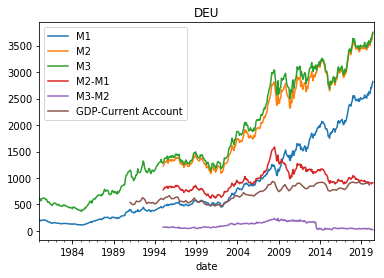

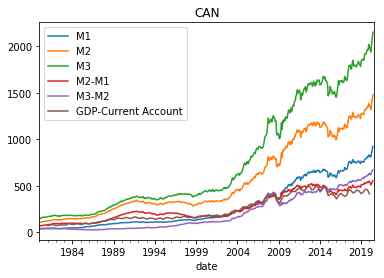

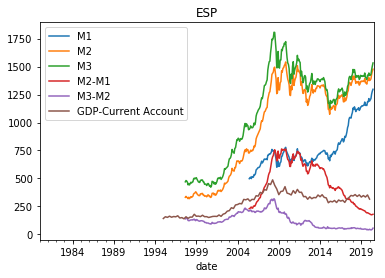

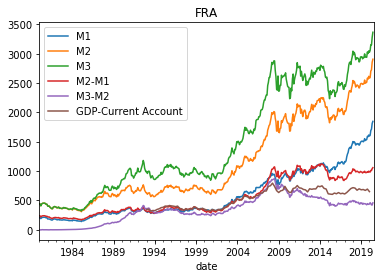

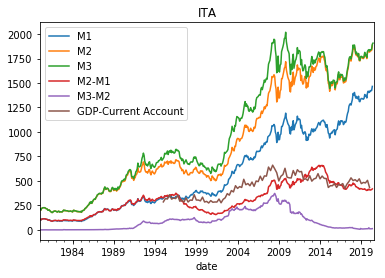

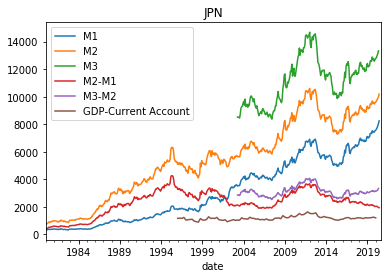

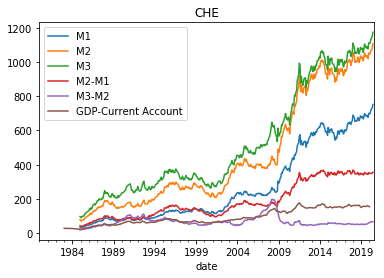

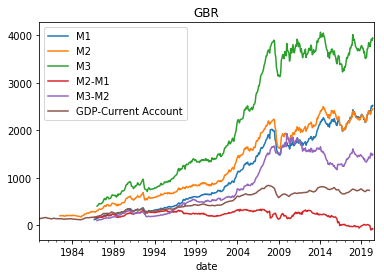

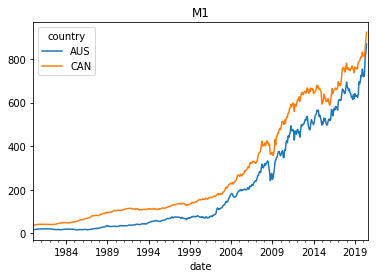

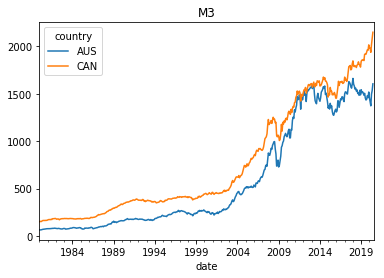

In [109]:
m1 = dl.pull('M1/inUSD')
m2 = dl.pull('M2/inUSD')
m3 = dl.pull('M3/inUSD')
m1m2Diff = m2.sub(m1)
m2m3Diff = m3.sub(m2)
gdpNom = dl.pull('GDP/Nominal')
currentAccountNom = dl.pull('CurrAcctNom/inUSD')
gdpMinusCurrentAccount = gdpNom.sub(currentAccountNom)

for country in m1.columns:
    if country not in ['AUS', 'USA']:
        m1[country].plot()
        m2[country].plot()
        m3[country].plot()
        m1m2Diff[country].plot()
        m2m3Diff[country].plot()
        gdpMinusCurrentAccount[country].plot()
        plt.legend(['M1', 'M2', 'M3', 'M2-M1', 'M3-M2', 'GDP-Current Account'])
        plt.title(country)
        plt.show()
        
m1[['AUS','CAN']].plot()
plt.title('M1')
plt.show()
m3[['AUS','CAN']].plot()
plt.title('M3')
plt.show()

I feel using gdp - current account seems to be the best indicator. I feel like this takes into account all the less liquid assets besides the things purchased. Also, Canada seems to be the best indicator for Australia since their charts appear to be the closest matching and the heuristic of using GDP - current account works very well for Canada.